In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Read the PISA data

We load the scheme from the scheme file and then import the data.

In [2]:
schemeFile = "resources/Global/education/PISA_SCHOOL_2012_read_SPSS.txt"
dataFile = "resources/Global/education/PISA_SCHOOL_2012_data_INT_SCQ12_DEC03.txt"

In [3]:
# Skip first two rows...
header = 2

sectionSplitter = "."

labelsStart = "variable labels" # where does the labels start
valueLabelsStart = "value labels" # where do the value labels start
missingValuesStart = "Missing values "

tmp_value_labels = None # the first value label has no heading "/"

# The order of the things to read...
thingsToRead = ["valuesRangeKind", "variableLabels", "valueLabels", "missingValues"]
started2Read = [False,             False,            False,         False]

readValuesSlices = {}
maxStop = 0
with open(schemeFile, "rb") as f:
    for lineNum, l in enumerate(f):
        if lineNum < header: continue
            
        if thingsToRead[0] == "valuesRangeKind":
            '''
            CNT 1 - 3 (A)
            SUBNATIO 4 - 10 (A)
            STRATUM 11 - 17 (A)
            '''
            if l[0] == sectionSplitter:
                thingsToRead.pop(0)
                started2Read.pop(0)
                continue  
            indicator, start, _, stop, kind = l.strip().split()
            start, stop = int(start)-1, int(stop)
            kind = kind[1]
            maxStop = max(stop, maxStop)
            readValuesSlices[indicator] = {"kind": kind, "start": start, "stop": stop,\
                                           "dictionary": {}, "missingValues": [], "label": ""}
            
        elif thingsToRead[0] == "variableLabels":
            '''
            CNT         "Country code 3-character" 
            OECD        "OECD country"                
            SUBNATIO    "Adjudicated sub-region code 7-digit code (3-digit country code + region ID + stratum ID)"
            STRATUM     "Stratum ID 7-character (cnt + region ID + original stratum ID)"
            '''
            if l[0] == sectionSplitter:
                thingsToRead.pop(0)
                started2Read.pop(0)
                continue
            elif not started2Read[0]:
                if l.startswith(labelsStart):
                    started2Read[0] = True
                continue
                
            vals = l.split('"')
            indicator = vals[0].replace(" ", "").replace("\t", "")
            label = vals[1]
            readValuesSlices[indicator]["label"] = label # Stripe away the apices "..."
            
        elif thingsToRead[0] == "valueLabels":
            '''
            /STRATUM 
            "ALB0001"  "ALB - stratum 01 : North, Urban, Public"
            '''
            
            if l[0] == sectionSplitter:
                thingsToRead.pop(0)
                started2Read.pop(0)
                continue
            elif not started2Read[0]:
                if l.startswith(valueLabelsStart):
                    started2Read[0] = True
                continue
            
            if tmp_value_labels is None:
                tmp_value_labels = l.strip().split() # Leave the initial /
                continue
            elif l.startswith("/"):
                tmp_value_labels = l.strip()[1:].split() # Leave the initial /
                continue
            
            try:
                vals = l.strip().split('"')
                if readValuesSlices[tmp_value_labels[0]]["kind"] == "A":
                    indicator = vals[1].replace(" ", "").replace("\t", "")
                    label = vals[3].replace("\t", "")
                elif readValuesSlices[tmp_value_labels[0]]["kind"] == "F":
                    indicator = float(vals[0].replace(" ", "").replace("\t", ""))
                    label = vals[1].replace("\t", "")

            except Exception as e:
                print l, vals
                print str(e)
                break
            for tmp_indic in tmp_value_labels:
                readValuesSlices[tmp_indic]["dictionary"][indicator] = label
                
        elif thingsToRead[0] == "missingValues":
            # No header this time!
            '''
            Missing values OECD (9,8,7).
            '''
            
            if l[0] == sectionSplitter:
                thingsToRead.pop(0)
                started2Read.pop(0)
                continue
            
            if not l.strip().startswith(missingValuesStart):
                continue
                
            tmp_vals = l.strip().split(missingValuesStart)[1].split()
            assert len(tmp_vals) == 2
            assert tmp_vals[1][0] == "("
            assert tmp_vals[1][-2:] == ")."
            
            tmp_indicator = tmp_vals[0]
            tmp_missing = tmp_vals[1][1:-2].split(",")
            
            if readValuesSlices[tmp_indicator]["kind"] == "F":
                tmp_missing = [float(v) for v in tmp_missing]
            if readValuesSlices[tmp_indicator]["kind"] == "A":
                tmp_missing = [v[1:-1] for v in tmp_missing] # Strip away the '..'
            
            readValuesSlices[tmp_indicator]["missingValues"] = tmp_missing

In [4]:
readValuesSlices["SC05Q01"]

{'dictionary': {'01': '15 students or lower',
  '02': '16-20 students',
  '03': '21-25 students',
  '04': '26-30 students',
  '05': '31-35 students',
  '06': '36-40 students',
  '07': '41-45 students',
  '08': '46-50 students',
  '09': 'More than 50 students',
  '97': 'N/A',
  '98': 'Invalid',
  '99': 'Missing'},
 'kind': 'A',
 'label': 'Class size in <test language>',
 'missingValues': ['99', '98', '97'],
 'start': 70,
 'stop': 72}

In [5]:
answers = []
with open(dataFile, "rb") as f:
    for l in f:
        vals = l.strip()
        
        assert len(vals) == maxStop
        
        tmp_answer = {}
        for indicator, indicatorFeatures in readValuesSlices.iteritems():
            tmp_val = vals[indicatorFeatures["start"]:indicatorFeatures["stop"]]
            
            tmp_val = float(tmp_val) if indicatorFeatures["kind"] == "F" else tmp_val
            if tmp_val in indicatorFeatures["missingValues"]:
                tmp_val = np.NaN
            
            tmp_answer[indicator] = tmp_val
        answers.append(tmp_answer)

In [6]:
dfAnswers = pd.DataFrame(answers)
dfAnswers.head()

,ABGMATH,ASSESS,CLSIZE,CNT,COMPWEB,CREACTIV,LEADCOM,LEADINST,LEADPD,LEADTCH,...,STRATUM,STUDCLIM,SUBNATIO,TCFOCST,TCHPARTI,TCMORALE,TCSHORT,TEACCLIM,VER_SCQ,W_FSCHWT
0,3.0,NaN,33.0,ALB,0.882,3.0,0.7162,0.0432,1.0394,0.4499,...,ALB0006,0.8936,0080000,0.0095,0.2924,-0.7371,1.7565,0.2464,28NOV13,8.4871
1,2.0,NaN,23.0,ALB,1.000,2.0,0.3404,-0.5037,-0.3717,-0.3206,...,ALB0005,1.9580,0080000,0.7020,-0.5646,0.4686,-0.2817,0.8778,28NOV13,1.0039
2,2.0,6.0,13.0,ALB,NaN,1.0,0.8948,0.4930,0.3739,0.6907,...,ALB0007,2.7520,0080000,1.2831,-0.5646,1.4452,0.7093,1.4756,28NOV13,8.3450
3,2.0,NaN,28.0,ALB,1.000,3.0,1.0746,0.2753,0.6627,-0.3206,...,ALB0001,-0.6182,0080000,1.2831,-0.1437,1.4452,-0.2817,-0.4382,28NOV13,8.4388
4,2.0,NaN,33.0,ALB,0.567,3.0,1.0746,0.9289,1.0394,0.2118,...,ALB0005,-1.2067,0080000,0.0095,-1.0488,-0.7371,0.4567,-0.8958,28NOV13,2.6435


In [7]:
country = "ITA"
print readValuesSlices["CNT"]["dictionary"][country]
len(dfAnswers[dfAnswers["CNT"] == country].SCHOOLID.unique()), len(dfAnswers[dfAnswers["CNT"] == country])

Italy


(1194, 1194)

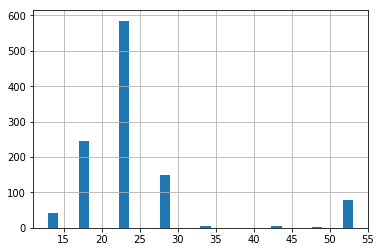

In [8]:
dfAnswers[dfAnswers["CNT"] == country]["CLSIZE"].hist(bins=30)

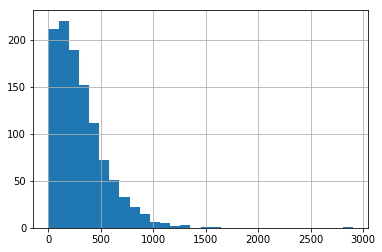

In [9]:
dfAnswers[dfAnswers["CNT"] == country]["SC07Q01"].hist(bins=30)

In [10]:
dfAnswers["SC07Q01"].describe()

count    16870.000000
mean       373.409129
std        363.677745
min          0.000000
25%        137.000000
50%        288.000000
75%        503.000000
max       5896.000000
Name: SC07Q01, dtype: float64

In [11]:
schoolSize = {}
bins = np.arange(5, 1505, 20)

for country in dfAnswers["CNT"].unique():
    tmp_data = dfAnswers[dfAnswers["CNT"] == country]["SC07Q01"].copy(deep=True)
    
    tmp_data.dropna(inplace=True)
    
    if tmp_data.count() == 0:
        continue
    tmp_data = tmp_data[tmp_data>= bins[0]]
    
    if len(tmp_data) < 5:
        continue
        
    f, b = np.histogram(tmp_data, bins=bins, density=True)
    
    schoolSize[country] = {"BINS": bins, "PDF": f, "CDF": np.cumsum(f*np.diff(b)), "RAW": tmp_data.values}
    
# Saving the average
tmp_data = dfAnswers["SC07Q01"]
tmp_data.dropna(inplace=True)
tmp_data = tmp_data[tmp_data>0]
f, b = np.histogram(tmp_data, bins=bins, density=True)
schoolSize["AVG"] = {"BINS": b, "PDF": f, "CDF": np.cumsum(f*np.diff(b)), "RAW": tmp_data.values}

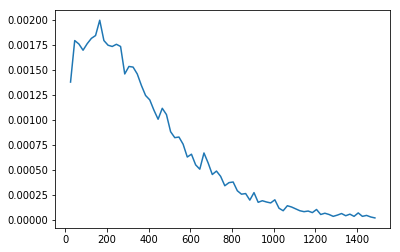

In [13]:
plt.plot(b[1:], f)

In [14]:
# Load the data from first step to include all the NUTS0 codes...
df_reference = pd.read_pickle("resources/Europe/population/structure/dataframes/2011_ageBySex_PDF.pkl")
indexes = df_reference[df_reference.index.str.len() == 2].index
print sorted(indexes)

[u'AT', u'BE', u'BG', u'CH', u'CY', u'CZ', u'DE', u'DK', u'EE', u'EL', u'ES', u'FI', u'FR', u'HR', u'HU', u'IE', u'IS', u'IT', u'LI', u'LT', u'LU', u'LV', u'MT', u'NL', u'NO', u'PL', u'PT', u'RO', u'SE', u'SI', u'SK', u'UK']


In [15]:
print sorted(dfAnswers["CNT"].unique())

['ALB', 'ARE', 'ARG', 'AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HKG', 'HRV', 'HUN', 'IDN', 'IRL', 'ISL', 'ISR', 'ITA', 'JOR', 'JPN', 'KAZ', 'KOR', 'LIE', 'LTU', 'LUX', 'LVA', 'MAC', 'MEX', 'MNE', 'MYS', 'NLD', 'NOR', 'NZL', 'PER', 'POL', 'PRT', 'QAT', 'QCN', 'QRS', 'ROU', 'RUS', 'SGP', 'SRB', 'SVK', 'SVN', 'SWE', 'TAP', 'THA', 'TUN', 'TUR', 'URY', 'USA', 'VNM']


In [16]:
# define the mapping
CNT2NUTS0 = {"AUT": "AT", "BEL": "BE", "BGR": "BG", "CZE": "CZ", "DEU": "DE",
             "DNK": "DK", "EST": "EE", "ESP": "ES", "FIN": "FI", "GRC": "EL",
             "FRA": "FR", "HRV": "HR", "HUN": "HU", "IRL": "IE", "ISL": "IS",
             "ITA": "IT", "LTU": "LT", "LUX": "LU", "LVA": "LV", "NLD": "NL",
             "NOR": "NO", "POL": "PL", "PRT": "PT", "ROU": "RO", "SWE": "SE",
             "SVN": "SI", "SVK": "SK", "GBR": "UK",
            }

In [17]:
dfOut = {}
for cnt, nuts0 in CNT2NUTS0.iteritems():
    if cnt not in schoolSize:
        cnt = "AVG"
        
    dfOut[nuts0] = schoolSize[cnt]

dfOut = pd.DataFrame(dfOut)
dfOut = dfOut.transpose()
dfOut.head()

,BINS,CDF,PDF,RAW
AT,"[5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 2...","[0.02754356379988758, 0.06339391668228093, 0.0...","[0.001377178189994379, 0.0017925176441196677, ...","[543.0, 426.0, 834.0, 336.0, 995.0, 497.0, 171..."
BE,"[5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 2...","[0.0, 0.007407407407407408, 0.0333333333333333...","[0.0, 0.0003703703703703704, 0.001296296296296...","[646.0, 275.0, 555.0, 225.0, 495.0, 247.0, 113..."
BG,"[5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 2...","[0.02185792349726776, 0.04918032786885246, 0.0...","[0.001092896174863388, 0.001366120218579235, 0...","[177.0, 134.0, 181.0, 221.0, 494.0, 351.0, 477..."
CZ,"[5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 2...","[0.024096385542168672, 0.09638554216867469, 0....","[0.0012048192771084336, 0.0036144578313253013,...","[253.0, 203.0, 175.0, 241.0, 111.0, 246.0, 43...."
DE,"[5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 2...","[0.005128205128205128, 0.015384615384615385, 0...","[0.0002564102564102564, 0.0005128205128205128,...","[321.0, 624.0, 167.0, 144.0, 337.0, 250.0, 127..."


In [18]:
dfOut.to_pickle("resources/Europe/population/structure/dataframes/school_PISA_sizeDistribution_NUTS0.pkl")